# Loading the data set

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt                        
%matplotlib inline
from tqdm import tqdm
import logging
from tqdm import trange
from tqdm.contrib.logging import logging_redirect_tqdm
from fer import FER



# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset("train")
valid_files, valid_targets = load_dataset("valid")
test_files, test_targets = load_dataset("test")

# load list of dog names
#dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]
dog_names =glob("data/dogImages/train/*[0-9].*/*")
#'/home/geeks/Desktop/gfg/*[0-9].*

                 
#print(dog_names)


# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 6680 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
import random
from glob import glob
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)
#print(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


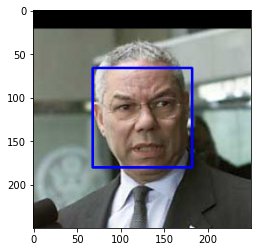

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier("\data\haarcascades\haarcascade_frontalface_alt.xml")

# load color (BGR) image
#img = cv2.imread(r"C:\Users\palla\Downloads\DL project\data\lfw\Aaron_Eckhart\Aaron_Eckhart_0001.jpg")
img=cv2.imread(human_files[47])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In the above code, faces is a numpy array of detected faces, where each row corresponds to a detected face. Each detected face is a 1D array with four entries that specifies the bounding box of the detected face. The first two entries in the array (extracted in the above code as x and y) specify the horizontal and vertical positions of the top left corner of the bounding box. The last two entries in the array (extracted here as w and h) specify the width and height of the box.


# Write a Human Face Detector

# Using Cv2 trying to detect the human face

In [4]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier("\data\data\haarcascades\haarcascade_frontalface_alt.xml")

# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

def detect_human_faces(images):
    """Detects human faces from images list
    
    return:
        face_count: count of identifies human faces from images
    """
    face_count = 0
    for pic in images:
        contains_face = face_detector(pic)
        if contains_face:
            face_count += 1
    return face_count

In [6]:
#Percentage of human faces in human_files
print(f'Percentage of human_faces in first 100 human_files {(detect_human_faces(human_files_short)/len(human_files_short))*100}')

#Percentage of human faces in dog_files
print(f'Percentage of human_faces in first 100 dog_files {(detect_human_faces(dog_files_short)/len(dog_files_short))*100}')

Percentage of human_faces in first 100 human_files 99.0
Percentage of human_faces in first 100 dog_files 12.0


# Age and gender Prediction for human dataset

In [7]:
# def run_emotion(img_path):
#     test_image_one = plt.imread(img_path)
#     plt.imshow(test_image_one)
#     emo_detector = FER(mtcnn=True)
#     captured_emotions = emo_detector.detect_emotions(test_image_one)
#     print(captured_emotions)
#     #plt.imshow(test_image_one)
#     dominant_emotion, emotion_score = emo_detector.top_emotion(test_image_one)
#     print(dominant_emotion, emotion_score) 

In [7]:
FACE_PROTO = r"\data\deploy.prototxt.txt"
FACE_MODEL = r"\data\res10_300x300_ssd_iter_140000_fp16.caffemodel"
AGE_PROTO = r"\data\age_net.caffemodel"
AGE_MODEL = r"\data\deploy_age.prototxt"
GENDER_PROTO = r"\data\gender_net.caffemodel"
GENDER_MODEL = r"\data\deploy_gender.prototxt"

In [8]:
AGE_INTERVALS = ['(0, 2)', '(4, 6)', '(8, 12)', '(15, 20)',
                 '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
GENDER_LIST = ['Male', 'Female']
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

In [9]:
# Initialize frame size
frame_width = 1280
frame_height = 720
# load face Caffe model
face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
# Load age prediction model
age_net = cv2.dnn.readNetFromCaffe(AGE_MODEL, AGE_PROTO)
# Load gender prediction model
gender_net = cv2.dnn.readNetFromCaffe(GENDER_MODEL, GENDER_PROTO)

In [10]:
def get_faces(frame, confidence_threshold=0.5):
    # convert the frame into a blob to be ready for NN input
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104, 177.0, 123.0))
    # set the image as input to the NN
    face_net.setInput(blob)
    # perform inference and get predictions
    output = np.squeeze(face_net.forward())
    # initialize the result list
    faces = []
    # Loop over the faces detected
    for i in range(output.shape[0]):
        confidence = output[i, 2]
        if confidence > confidence_threshold:
            box = output[i, 3:7] * \
                np.array([frame.shape[1], frame.shape[0],
                         frame.shape[1], frame.shape[0]])
            # convert to integers
            start_x, start_y, end_x, end_y = box.astype(np.int)
            # widen the box a little
            start_x, start_y, end_x, end_y = start_x - \
                10, start_y - 10, end_x + 10, end_y + 10
            start_x = 0 if start_x < 0 else start_x
            start_y = 0 if start_y < 0 else start_y
            end_x = 0 if end_x < 0 else end_x
            end_y = 0 if end_y < 0 else end_y
            # append to our list
            faces.append((start_x, start_y, end_x, end_y))
    return faces

In [11]:
def display_img(title, img):
    """Displays an image on screen and maintains the output until the user presses a key"""
    # Display Image on screen
    cv2.imshow(title, img)
    # Mantain output until user presses a key
    cv2.waitKey(0)
    # Destroy windows when user presses a key
    cv2.destroyAllWindows()

In [12]:

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]
    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image
    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))
    # resize the image
    return cv2.resize(image, dim, interpolation = inter)

In [13]:
def get_gender_predictions(face_img):
    blob = cv2.dnn.blobFromImage(
        image=face_img, scalefactor=1.0, size=(227, 227),
        mean=MODEL_MEAN_VALUES, swapRB=False, crop=False
    )
    gender_net.setInput(blob)
    return gender_net.forward()


def get_age_predictions(face_img):
    blob = cv2.dnn.blobFromImage(
        image=face_img, scalefactor=1.0, size=(227, 227),
        mean=MODEL_MEAN_VALUES, swapRB=False
    )
    age_net.setInput(blob)
    return age_net.forward()

In [14]:
def predict_age_and_gender(input_path: str):
    """Predict the gender of the faces showing in the image"""
    # Initialize frame size
    # frame_width = 1280
    # frame_height = 720
    # Read Input Image
    img = cv2.imread(input_path)
    # resize the image, uncomment if you want to resize the image
    # img = cv2.resize(img, (frame_width, frame_height))
    # Take a copy of the initial image and resize it
    frame = img.copy()
    if frame.shape[1] > frame_width:
        frame = image_resize(frame, width=frame_width)
    # predict the faces
    faces = get_faces(frame)
    # Loop over the faces detected
    # for idx, face in enumerate(faces):
    for i, (start_x, start_y, end_x, end_y) in enumerate(faces):
        face_img = frame[start_y: end_y, start_x: end_x]
        age_preds = get_age_predictions(face_img)
        gender_preds = get_gender_predictions(face_img)
        i = gender_preds[0].argmax()
        gender = GENDER_LIST[i]
        gender_confidence_score = gender_preds[0][i]
        i = age_preds[0].argmax()
        age = AGE_INTERVALS[i]
        age_confidence_score = age_preds[0][i]
        # Draw the box
        label = f"{gender}-{gender_confidence_score*100:.1f}%, {age}-{age_confidence_score*100:.1f}%"
        # label = "{}-{:.2f}%".format(gender, gender_confidence_score*100)
        print(label)
        yPos = start_y - 15
        while yPos < 15:
            yPos += 15
        box_color = (255, 0, 0) if gender == "Male" else (147, 20, 255)
        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), box_color, 2)
        # Label processed image
        font_scale = 0.54
        cv2.putText(frame, label, (start_x, yPos),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, box_color, 2)

        # Display processed image
    #display_img("Gender Estimator", frame)
    # uncomment if you want to save the image
#     cv2.imwrite("output.jpg", frame)
#     # Cleanup
#     cv2.destroyAllWindows()

<ipython-input-10-0e5e02fad800>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_x, start_y, end_x, end_y = box.astype(np.int)


Female-99.7%, (25, 32)-91.8%


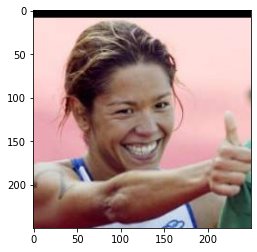

In [116]:
predict_age_and_gender(human_files[90])
face_cascade = cv2.CascadeClassifier(r"\haarcascades\haarcascade_frontalface_alt.xml")
img=cv2.imread(human_files[90])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

<ipython-input-10-0e5e02fad800>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_x, start_y, end_x, end_y = box.astype(np.int)


Male-100.0%, (38, 43)-98.6%
Female-53.3%, (4, 6)-97.2%


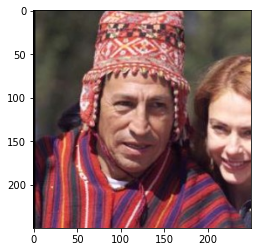

In [16]:
predict_age_and_gender(human_files[10])
face_cascade = cv2.CascadeClassifier(r"\data\haarcascades\haarcascade_frontalface_alt.xml")
img=cv2.imread(human_files[10])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

<ipython-input-10-0e5e02fad800>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_x, start_y, end_x, end_y = box.astype(np.int)


Male-100.0%, (25, 32)-46.1%
Male-52.1%, (4, 6)-76.7%


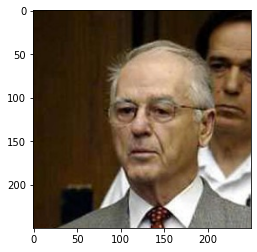

In [17]:
predict_age_and_gender(human_files[23])
face_cascade = cv2.CascadeClassifier(r"\data\haarcascades\haarcascade_frontalface_alt.xml")
img=cv2.imread(human_files[23])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

<ipython-input-10-0e5e02fad800>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_x, start_y, end_x, end_y = box.astype(np.int)


Male-75.9%, (15, 20)-65.5%


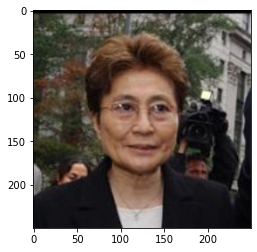

In [18]:
predict_age_and_gender(human_files[1])
face_cascade = cv2.CascadeClassifier(r"\data\haarcascades\haarcascade_frontalface_alt.xml")
img=cv2.imread(human_files[1])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

# Human Emotion detection

[{'box': [84, 59, 92, 122], 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 1.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}}]
happy 1.0


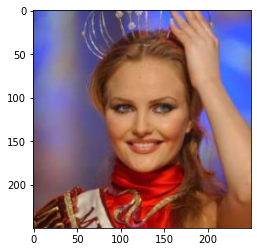

In [19]:

from fer import FER
import matplotlib.pyplot as plt 
%matplotlib inline
import cv2


# for file in human_files[:3]:
#     run_emotion(file)
    
# Testing on another image
test_image_four = plt.imread(human_files[2])
emo_detector = FER(mtcnn=True)
captured_emotions_four = emo_detector.detect_emotions(test_image_four)
print(captured_emotions_four)
plt.imshow(test_image_four)
dominant_emotion_four, emotion_score_four = emo_detector.top_emotion(test_image_four)
print(dominant_emotion_four, emotion_score_four)


[{'box': [84, 60, 94, 121], 'emotions': {'angry': 0.24, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.01, 'sad': 0.08, 'surprise': 0.01, 'neutral': 0.65}}]
neutral 0.65


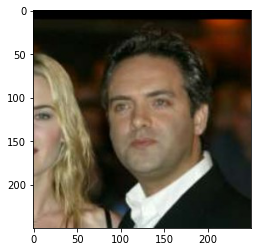

In [121]:
test_image_four = plt.imread(human_files[30])
emo_detector = FER(mtcnn=True)
captured_emotions_four = emo_detector.detect_emotions(test_image_four)
print(captured_emotions_four)
plt.imshow(test_image_four)
dominant_emotion_four, emotion_score_four = emo_detector.top_emotion(test_image_four)
print(dominant_emotion_four, emotion_score_four)


[{'box': [91, 65, 93, 125], 'emotions': {'angry': 0.46, 'disgust': 0.0, 'fear': 0.03, 'happy': 0.0, 'sad': 0.12, 'surprise': 0.0, 'neutral': 0.39}}, {'box': [183, 14, 79, 123], 'emotions': {'angry': 0.09, 'disgust': 0.0, 'fear': 0.12, 'happy': 0.02, 'sad': 0.36, 'surprise': 0.0, 'neutral': 0.42}}]
angry 0.46


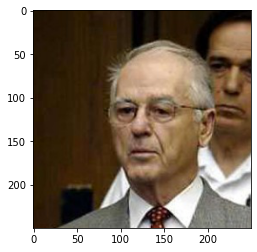

In [21]:
test_image_four = plt.imread(human_files[23])
emo_detector = FER(mtcnn=True)
captured_emotions_four = emo_detector.detect_emotions(test_image_four)
print(captured_emotions_four)
plt.imshow(test_image_four)
dominant_emotion_four, emotion_score_four = emo_detector.top_emotion(test_image_four)
print(dominant_emotion_four, emotion_score_four)


[]
None None


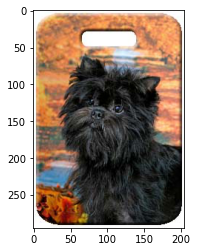

In [22]:
test_image_four = plt.imread(dog_names[39])
emo_detector = FER(mtcnn=True)
captured_emotions_four = emo_detector.detect_emotions(test_image_four)
print(captured_emotions_four)
plt.imshow(test_image_four)
dominant_emotion_four, emotion_score_four = emo_detector.top_emotion(test_image_four)
print(dominant_emotion_four, emotion_score_four)

As expected for dog images no emotion is detected

# Now we are making predictions using various pre trained models like VGG-16 Model , ResNet 50, densenet 161

# Obtain Pre-trained VGG-16 Model

In [23]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

# Making Predictions with a Pre-trained Model

In [24]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms

def model_predict(model, img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    model.eval()
    transform = transforms.Compose([
                                    transforms.Resize(224), 
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor()])
    img = Image.open(img_path)
    img = transform(img).float()
    img = img.unsqueeze(0)
    
    if use_cuda:
        img = img.cuda()
        
    predictions = model(img)
    _, index = predictions.max(1)
    
    return index.item() # predicted class index

# Write a Dog Detector with VGG16

In [25]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(model, img_path):
    ## TODO: Complete the function.
    index = model_predict(model, img_path)
    return index >= 151 and index<=268

In [26]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
from tqdm import tqdm
print(str(np.sum([dog_detector(VGG16, file) for file in tqdm(human_files_short)])) + '% of human images with a detected dog')
print(str(np.sum([dog_detector(VGG16, file) for file in tqdm(dog_files_short)])) + '% of dog images with a detected dog')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.13it/s]


0% of human images with a detected dog


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.14it/s]

96% of dog images with a detected dog


What percentage of the images in human_files_short have a detected dog? 0%

What percentage of the images in dog_files_short have a detected dog? 96%

Lets try other pre-trained models and access the performance

#  ResNet-50

In [27]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

Pre-Process the data

In [28]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [29]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [30]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [31]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

def detect_human_faces_keras(images):
    """Detects human faces from images list
    
    return:
        face_count: count of identifies human faces from images
    """
    face_count = 0
    for pic in images:
        contains_face = dog_detector(pic)
        if contains_face:
            face_count += 1
    return face_count

In [32]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

list_humans_as_dogs=0
for i in human_files_short:
    if dog_detector(i)==True:
        list_humans_as_dogs+=1
print("Performance for recognizing dogs in human images :" + str(list_humans_as_dogs))

list_dogs_as_dogs=0
for i in dog_files_short:
    if dog_detector(i)==True:
        list_dogs_as_dogs+=1
print("Performance for recognizing dogs in dog images :" + str(list_dogs_as_dogs))

Performance for recognizing dogs in human images :0
Performance for recognizing dogs in dog images :100


# densenet161

In [33]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(model, img_path):
    ## TODO: Complete the function.
    index = model_predict(model, img_path)
    return index >= 151 and index<=268

In [34]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

# define densenet161 model
densenet161 = models.densenet161(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    densenet161 = densenet161.cuda()
    
print(str(np.sum([dog_detector(densenet161, file) for file in tqdm(human_files_short)])) + '% of human images with a detected dog')
print(str(np.sum([dog_detector(densenet161, file) for file in tqdm(dog_files_short)])) + '% of dog images with a detected dog')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


0% of human images with a detected dog


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.89it/s]

98% of dog images with a detected dog


Performance for recognizing dogs in human images :0

Performance for recognizing dogs in dog images :98

# Create a CNN to Classify Dog Breeds (from Scratch)

In [35]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

transform = transforms.Compose([transforms.RandomRotation(10),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

#specify a simpler transform for validation and test
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
data_dir = r'/data/dogImages/'
train_dir = os.path.join(data_dir,'train/')
valid_dir = os.path.join(data_dir,'valid/')
test_dir = os.path.join(data_dir,'test/')

train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)

loaders_scratch = {'train' : train_loader, 'valid': valid_loader, 'test': test_loader}

In [36]:
import torch.nn as nn
import torch.nn.functional as F

n_dog_breed_classes = 133

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 16*224*224
        self.pool = nn.MaxPool2d(2, 2) # 16*112*112
        self.batchnorm1 = nn.BatchNorm2d(16) 
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 32*112*112
        # same MaxPool2d => 32*56*56
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 64*56*56
        # same MaxPool2d => 64*28*28
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # 128*28*28
        # same MaxPool2d => 128*14*14
        self.batchnorm4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1) # 256*14*14
        # same MaxPool2d => 256*7*7
        self.batchnorm5 = nn.BatchNorm2d(256)
                
        self.dropout = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(256*7*7, 1024)        
        self.batchnorm_fc1 = nn.BatchNorm1d(1024)
        
        self.fc2 = nn.Linear(1024, n_dog_breed_classes)    
    def forward(self, x):
        ## Define forward behavior
        # First Convolutional Layer with ReLU activation, 
        # then MaxPool2d to reduce dimension by 2, 
        # then batch normalization to speed up learning in hidden layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batchnorm1(x)
        
        # Second Convolutional Layer with same architecture... up to Five
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batchnorm2(x)
        
        x = self.pool(F.relu(self.conv3(x)))
        x = self.batchnorm3(x)
        
        x = self.pool(F.relu(self.conv4(x)))
        x = self.batchnorm4(x)
        
        x = self.pool(F.relu(self.conv5(x)))
        x = self.batchnorm5(x)
        
        #Flatten for Fully Connected layers
        x = self.dropout(x.view(-1, 256*7*7))
        
        #First Fully Connected network
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.batchnorm_fc1(x)
        
        #Second Fully Connected Network
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [37]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adagrad(model_scratch.parameters(), lr=0.01)

In [38]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)            
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [39]:
# train the model
n_epochs = 10
model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, r'\model_scratch.pt1')

Epoch: 1 	Training Loss: 5.019734 	Validation Loss: 4.454955
Validation loss decreased (inf --> 4.454955).  Saving model ...
Epoch: 2 	Training Loss: 4.543531 	Validation Loss: 4.308497
Validation loss decreased (4.454955 --> 4.308497).  Saving model ...
Epoch: 3 	Training Loss: 4.359116 	Validation Loss: 4.104485
Validation loss decreased (4.308497 --> 4.104485).  Saving model ...
Epoch: 4 	Training Loss: 4.247845 	Validation Loss: 3.972532
Validation loss decreased (4.104485 --> 3.972532).  Saving model ...
Epoch: 5 	Training Loss: 4.103523 	Validation Loss: 3.880223
Validation loss decreased (3.972532 --> 3.880223).  Saving model ...
Epoch: 6 	Training Loss: 3.976525 	Validation Loss: 3.684030
Validation loss decreased (3.880223 --> 3.684030).  Saving model ...
Epoch: 7 	Training Loss: 3.898399 	Validation Loss: 3.630387
Validation loss decreased (3.684030 --> 3.630387).  Saving model ...
Epoch: 8 	Training Loss: 3.784017 	Validation Loss: 3.533628
Validation loss decreased (3.63038

In [40]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(r'\model_scratch.pt1'))

<All keys matched successfully>

In [41]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [42]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.438653


Test Accuracy: 18% (154/836)


# Transfer Learning

In [43]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch

In [44]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
#model_transfer = models.vgg16(pretrained=True)
model_transfer = models.densenet161(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
n_inputs = model_transfer.classifier.in_features

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, n_dog_breed_classes)

#model_transfer.classifier[6] = last_layer
model_transfer.classifier = last_layer

if use_cuda:
    model_transfer = model_transfer.cuda()

In [45]:
criterion_transfer = nn.CrossEntropyLoss()
#optimizer_transfer = optim.Adagrad(model_transfer.classifier[6].parameters(), lr=0.01)
optimizer_transfer = optim.Adagrad(model_transfer.classifier.parameters(), lr=0.01)

In [46]:
# train the model
n_epochs=8
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer,
                       use_cuda, r'\model_transfer.pt')

Epoch: 1 	Training Loss: 2.298609 	Validation Loss: 0.832451
Validation loss decreased (inf --> 0.832451).  Saving model ...
Epoch: 2 	Training Loss: 1.135001 	Validation Loss: 0.597334
Validation loss decreased (0.832451 --> 0.597334).  Saving model ...
Epoch: 3 	Training Loss: 0.927483 	Validation Loss: 0.500998
Validation loss decreased (0.597334 --> 0.500998).  Saving model ...
Epoch: 4 	Training Loss: 0.824227 	Validation Loss: 0.459915
Validation loss decreased (0.500998 --> 0.459915).  Saving model ...
Epoch: 5 	Training Loss: 0.786907 	Validation Loss: 0.437760
Validation loss decreased (0.459915 --> 0.437760).  Saving model ...
Epoch: 6 	Training Loss: 0.758468 	Validation Loss: 0.406707
Validation loss decreased (0.437760 --> 0.406707).  Saving model ...
Epoch: 7 	Training Loss: 0.710961 	Validation Loss: 0.380885
Validation loss decreased (0.406707 --> 0.380885).  Saving model ...
Epoch: 8 	Training Loss: 0.675979 	Validation Loss: 0.382954


In [47]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load(r'\model_transfer.pt'))

<All keys matched successfully>

In [48]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.412027


Test Accuracy: 89% (749/836)


In [79]:
from torchvision import models
print(model_transfer)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

# Predict the dog breed and for humans predict the dog breed closing resembling the images

In [49]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

data_transfer = {'train' : train_data, 'valid': valid_data, 'test': test_data}

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    model_transfer.eval()
    transform = transforms.Compose([
                                    transforms.Resize(224), 
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor()])
    img = Image.open(img_path)
    img = transform(img).float()
    img = img.unsqueeze(0)
    
    if use_cuda:
        img = img.cuda()
        
    predictions = model_transfer(img)
    _, index = predictions.max(1)
    
    return class_names[index.item()]

In [50]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def show_image(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)  
    plt.show()  

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    show_image(img_path)
    if dog_detector(densenet161, img_path):
#         print('Hello human')
#         print('You look like a ' + predict_breed_transfer(img_path))
        print('Hello dog')
        print('I predict you are a ' + predict_breed_transfer(img_path))
    elif face_detector(img_path):
        print('Hello human')
        predict_age_and_gender(img_path)
        print('If you were a dog you would look like ' + predict_breed_transfer(img_path))
        
    else:
        print('I cannot see any dog or human here!!!')
    print('________________________________________________________________________')

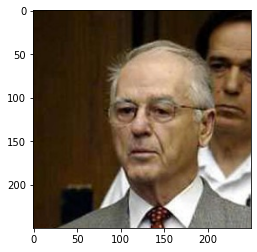

Hello human
Male-100.0%, (25, 32)-46.1%
Male-52.1%, (4, 6)-76.7%


<ipython-input-10-0e5e02fad800>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_x, start_y, end_x, end_y = box.astype(np.int)


If you were a dog you would look like English cocker spaniel
________________________________________________________________________


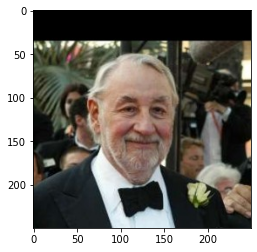

Hello human
Male-99.9%, (0, 2)-98.9%
If you were a dog you would look like Irish water spaniel
________________________________________________________________________


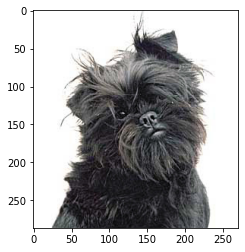

Hello dog
I predict you are a Affenpinscher
________________________________________________________________________


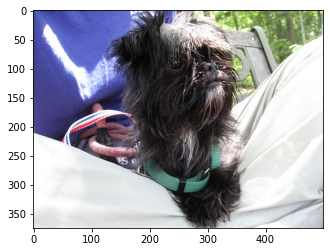

Hello dog
I predict you are a Affenpinscher
________________________________________________________________________


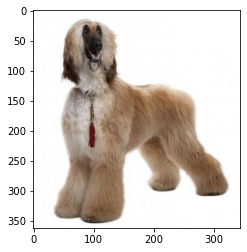

Hello dog
I predict you are a Afghan hound
________________________________________________________________________


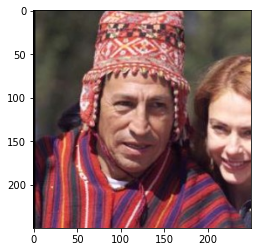

Hello human
Male-100.0%, (38, 43)-98.6%
Female-53.3%, (4, 6)-97.2%
If you were a dog you would look like Pharaoh hound
________________________________________________________________________


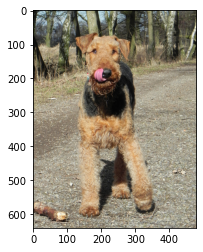

Hello dog
I predict you are a Airedale terrier
________________________________________________________________________


In [75]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[23:25], dog_names[16])):
     run_app(file)
for file in np.hstack((dog_names[3], dog_names[102])):
    run_app(file)
for file in np.hstack((human_files[10], dog_names[133])):
    run_app(file)
# for file in np.hstack((human_files[20:25], dog_names[72])):
#     run_app(file)

In [58]:
def run_app__real_images(img_path):
    ## handle cases for a human face, dog, and neither
    show_image(img_path)
    if face_detector(img_path):
        print('Hello human')
        predict_age_and_gender(img_path)
        print('If you were a dog you would look like ' + predict_breed_transfer(img_path))
    if dog_detector(densenet161, img_path):
        
        print('Hello dog')
        print('I predict you are a ' + predict_breed_transfer(img_path))
        
    else:
        print('I cannot see any dog or human here!!!')
    print('________________________________________________________________________')

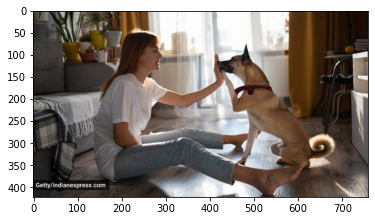

Hello dog
I predict you are a Italian greyhound
________________________________________________________________________


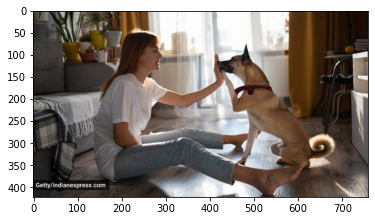

Hello dog
I predict you are a Italian greyhound
________________________________________________________________________


In [62]:
for file in (r"\data\cnn.jpg",r"\data\cnn.jpg"):
    run_app__real_images(file)

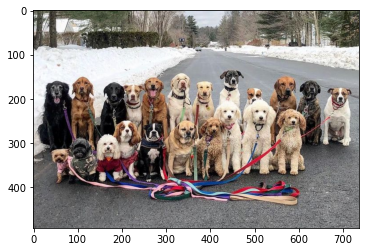

Hello human
Male-100.0%, (25, 32)-78.2%
Male-99.0%, (0, 2)-86.8%
Male-99.2%, (60, 100)-69.2%


<ipython-input-10-0e5e02fad800>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_x, start_y, end_x, end_y = box.astype(np.int)


If you were a dog you would look like Anatolian shepherd dog
I cannot see any dog or human here!!!
________________________________________________________________________


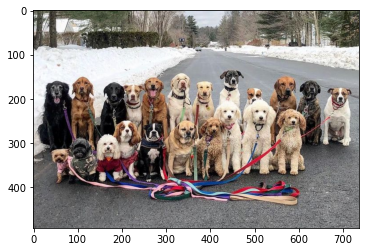

Hello human
Male-100.0%, (25, 32)-78.2%
Male-99.0%, (0, 2)-86.8%
Male-99.2%, (60, 100)-69.2%
If you were a dog you would look like Anatolian shepherd dog
I cannot see any dog or human here!!!
________________________________________________________________________


In [63]:
for file in (r"\data\multipledogs.jpg",r"\data\multipledogs.jpg"):
    run_app__real_images(file)

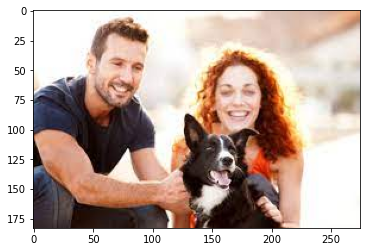

Hello human
Female-100.0%, (38, 43)-57.4%
Male-100.0%, (25, 32)-99.9%


<ipython-input-10-0e5e02fad800>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_x, start_y, end_x, end_y = box.astype(np.int)


If you were a dog you would look like Cardigan welsh corgi
Hello dog
I predict you are a Cardigan welsh corgi
________________________________________________________________________


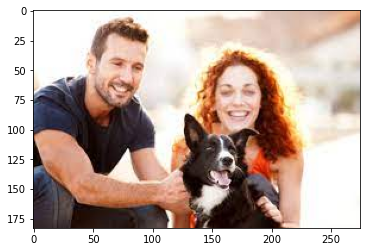

Hello human
Female-100.0%, (38, 43)-57.4%
Male-100.0%, (25, 32)-99.9%
If you were a dog you would look like Cardigan welsh corgi
Hello dog
I predict you are a Cardigan welsh corgi
________________________________________________________________________


In [65]:
for file in (r"\data\manwomandog.jpg",r"\data\manwomandog.jpg"):
    run_app__real_images(file)

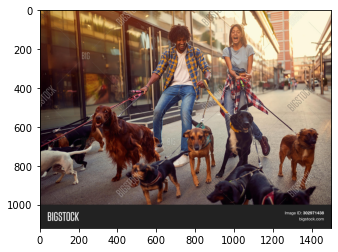

Hello human
If you were a dog you would look like Dachshund
Hello dog
I predict you are a Dachshund
________________________________________________________________________


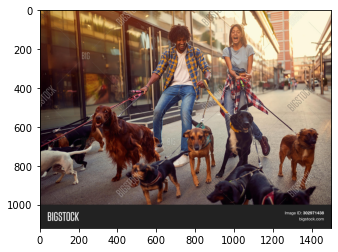

Hello human
If you were a dog you would look like Dachshund
Hello dog
I predict you are a Dachshund
________________________________________________________________________


In [66]:
for file in (r"\data\peopledogs.jpg",r"\data\peopledogs.jpg"):
    run_app__real_images(file)

# Data Exploration

In [89]:
def plot_breed(df):
    labels = []
    for i in range(df.shape[0]):
        labels.append(dog_names[np.argmax(df[i])])

    df_labels = pd.DataFrame(np.array(labels), columns=["breed"]).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10,30))
    df_labels['breed'].value_counts().plot(ax=ax, kind='barh').invert_yaxis()
    ax.set_title('Distribution of Dog breeds')

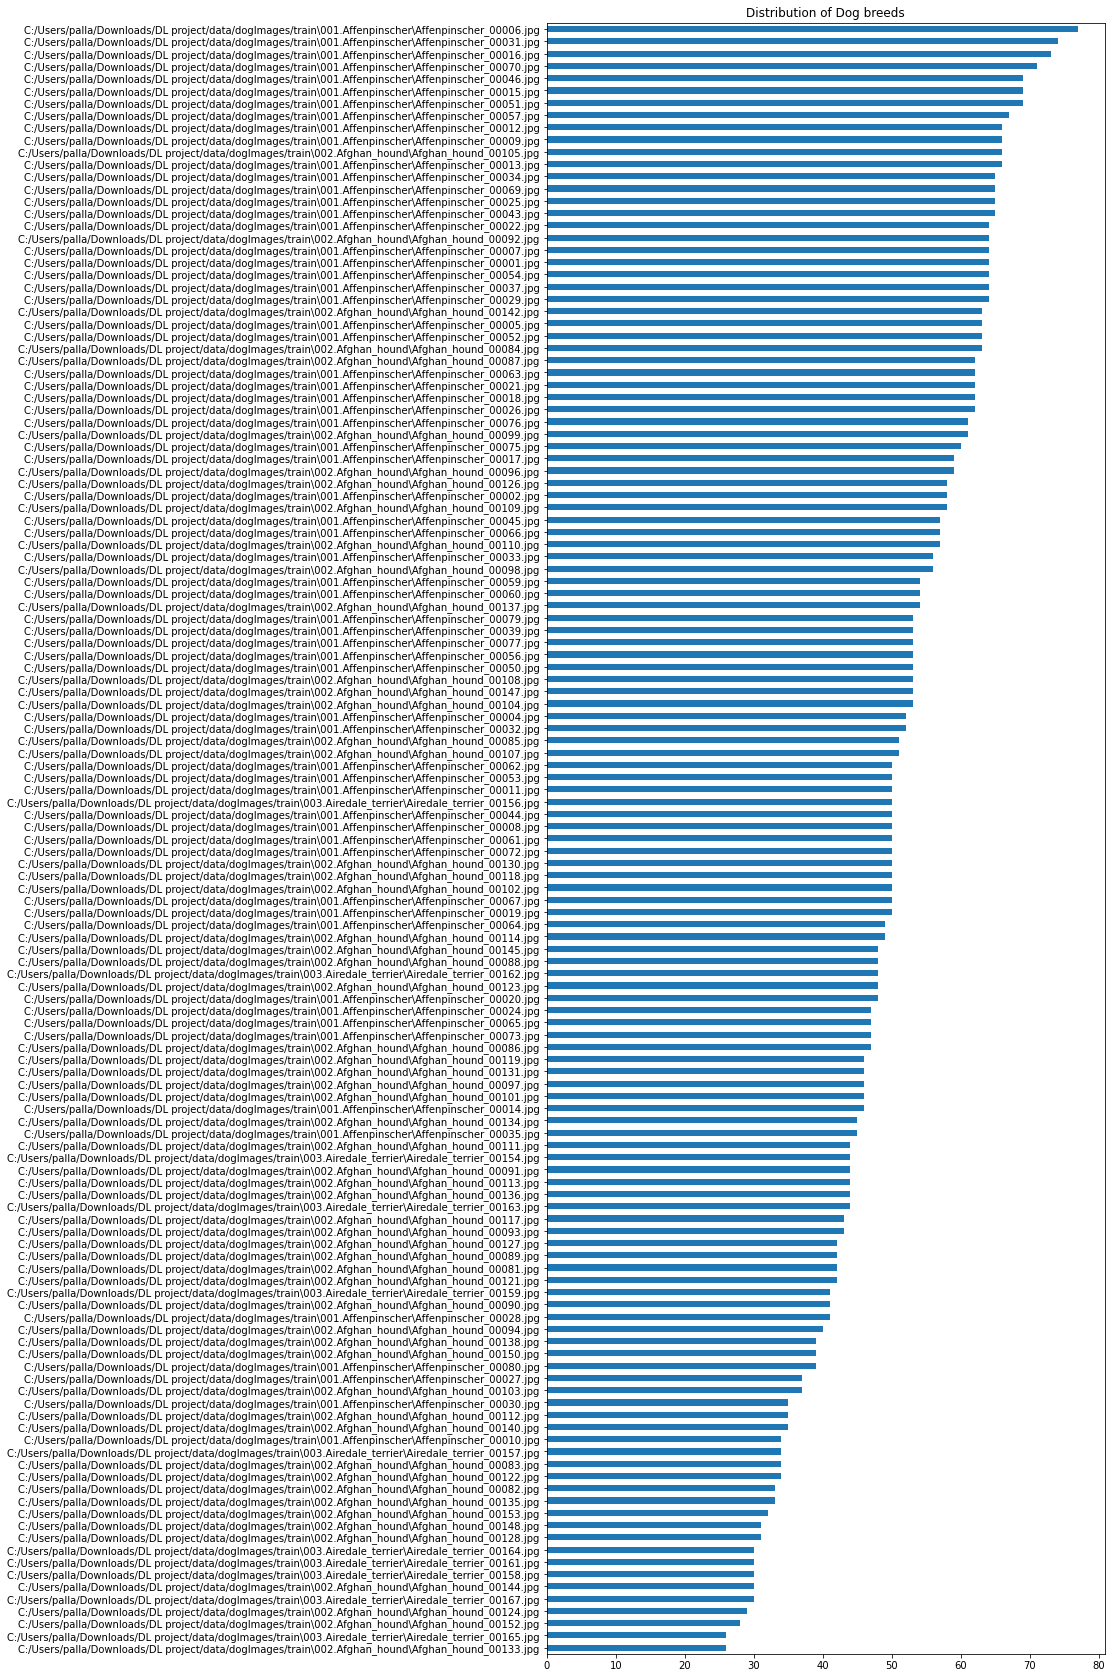

In [90]:
plot_breed(train_targets)

In [91]:
def display_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    return imgplot

In [92]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#### this function returns the shape of image, image itself and the  intensity distribution of an image
def img_hist(df_image, label):
    img = cv2.imread(df_image)
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
        
    print(dog_names[np.argmax(label)])
    print(img.shape)
    plt.show()
    #plt.imshow(img)
    display_img(df_image)

C:/Users/palla/Downloads/DL project/data/dogImages/train\001.Affenpinscher\Affenpinscher_00009.jpg
(320, 320, 3)


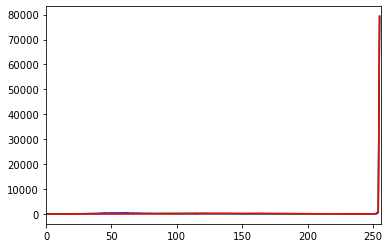

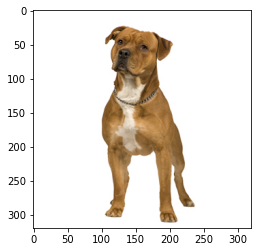

In [93]:
## here I checked the image sizes, and the  intensity distribution of images from the same breed
## and the result shows images have different resolution, zoom and lightening conditins even for the same breed
## it makes this task even more challenging 
img_hist(train_files[3], train_targets[3])

C:/Users/palla/Downloads/DL project/data/dogImages/train\001.Affenpinscher\Affenpinscher_00013.jpg
(400, 390, 3)


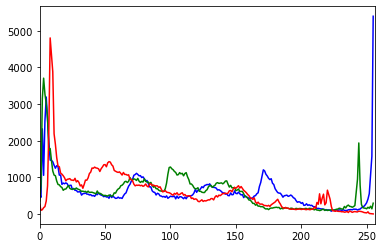

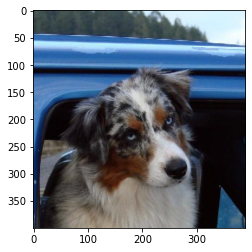

In [94]:
img_hist(train_files[10],train_targets[10])

C:/Users/palla/Downloads/DL project/data/dogImages/train\001.Affenpinscher\Affenpinscher_00012.jpg
(400, 267, 3)


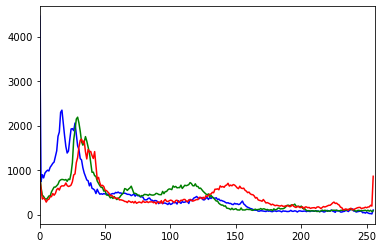

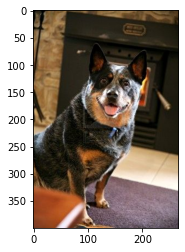

In [96]:
img_hist(train_files[99], train_targets[99])

In [97]:
## find the list of labels and save them as a pandas data 
labels_train = []
labels_test = []

for i in range(train_files.shape[0]):
    labels_train.append(dog_names[np.argmax(train_targets[i])])
    
for i in range(test_files.shape[0]):
    labels_test.append(dog_names[np.argmax(test_targets[i])])

In [98]:
from sklearn.preprocessing import LabelEncoder

## this function plot the breeds distribution in train data 
def dist_breed(labels):
    encoder = LabelEncoder()
    breeds_encoded = encoder.fit_transform(labels)
    n_classes = len(encoder.classes_)
    
    breeds = pd.DataFrame(np.array(breeds_encoded), columns=["breed"]).reset_index(drop=True)
    breeds['freq'] = breeds.groupby('breed')['breed'].transform('count')
    avg = breeds.freq.mean()
    
    title = 'Distribution of Dog Breeds in training Dataset\n (%3.0f samples per class on average)' % avg
    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.set_xticks([])
    
    ax.hlines(avg, 0, n_classes - 1, color='white')
    ax.set_title(title, fontsize=18)
    _ = ax.hist(breeds_encoded, bins=n_classes)
    
    return(breeds["freq"].describe())

count    6680.000000
mean       53.006886
std        11.377801
min        26.000000
25%        46.000000
50%        53.000000
75%        63.000000
max        77.000000
Name: freq, dtype: float64

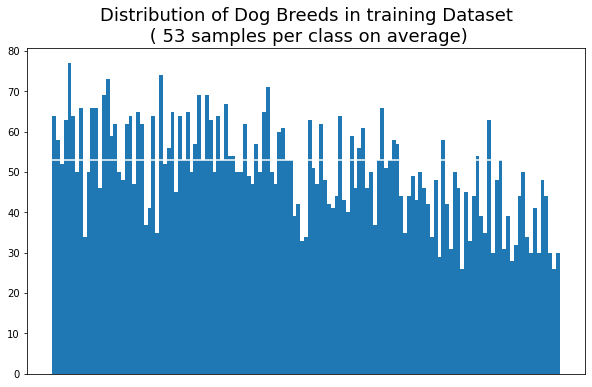

In [100]:
dist_breed(labels_train)

count    836.000000
mean       6.748804
std        1.641982
min        3.000000
25%        6.000000
50%        7.000000
75%        8.000000
max       10.000000
Name: freq, dtype: float64

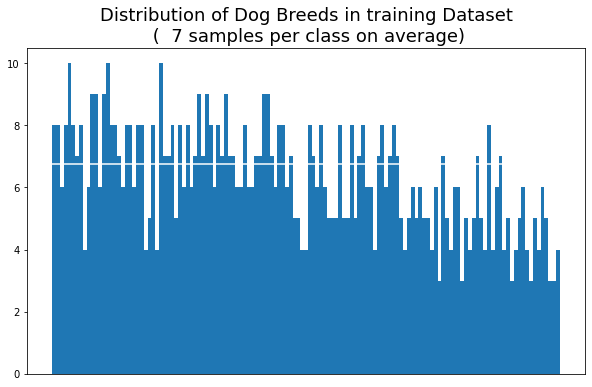

In [105]:
dist_breed(labels_test)

In [101]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImages(list_of_files, col=10, wSize=5, hSize=5, mypath='.'):
    fig = figure(figsize=(wSize, hSize))
    number_of_files = len(list_of_files)
    row = 10
    if (number_of_files % col != 0):
        row += 1
    for i in range(row+10):
        a=fig.add_subplot(row, col, i + 1)
        image = imread(list_of_files[i])
        imshow(image)
        axis('off')

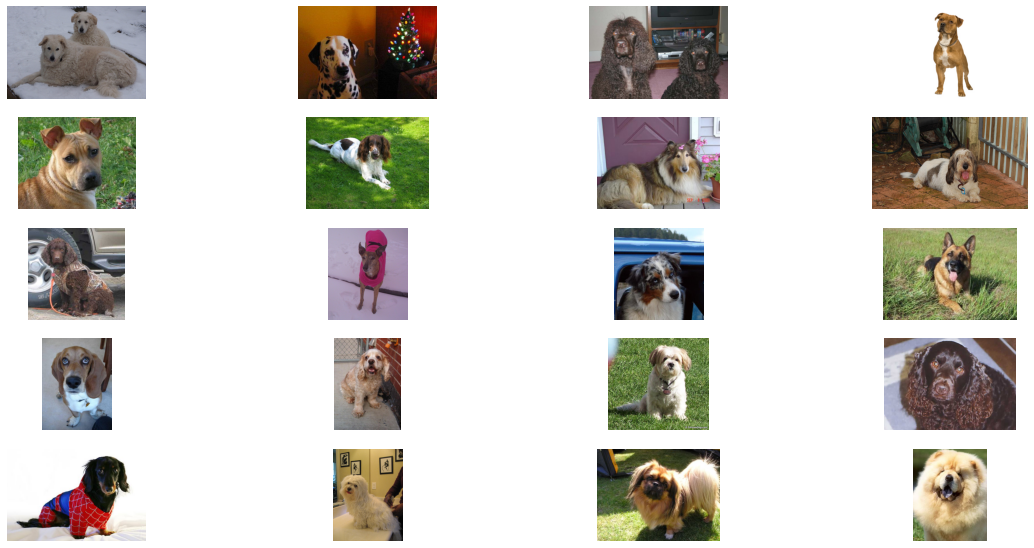

In [118]:
showImages(train_files, wSize=20, hSize=20, col=4)

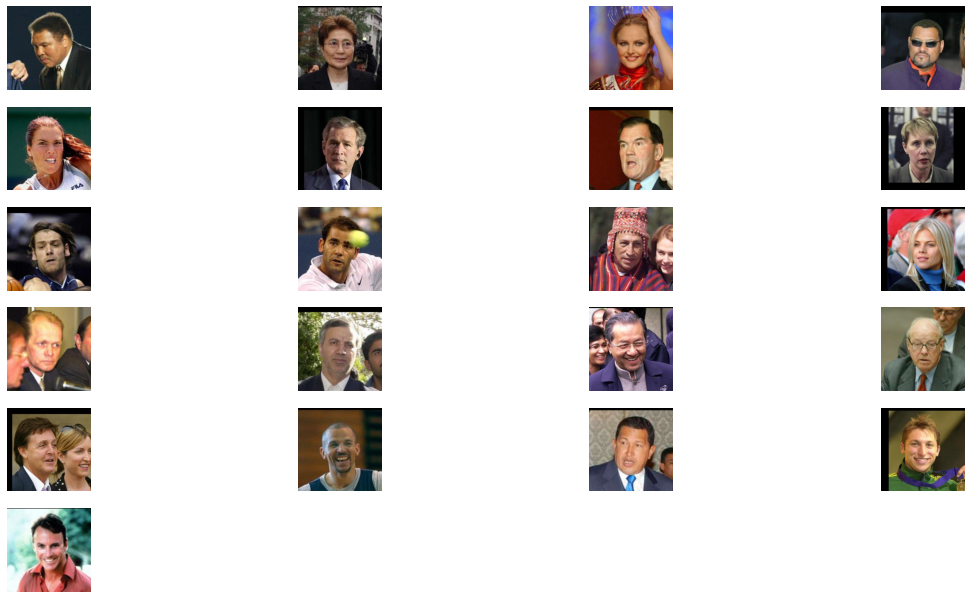

In [117]:
showImages(human_files, wSize=20, hSize=20, col=4)